## Process Data


### Import Nescessary Library

In [15]:
import data_utils as dt #Read Json file and create diction of text and markup
import Error_Checking as ck
import string
import math
import nltk
from difflib import SequenceMatcher 
import matplotlib.pyplot as plt

### Read the data

In [16]:
# Data is a list of dictionaries of text and its markup
data = dt.process_data('Data/tai-documents-v3/tai-documents-v3.json')

In [17]:
len(data)

210

In [18]:
type(data)

list

In [19]:
type(data[0])

dict

In [20]:
data[0].keys()

dict_keys(['plaintext', 'markup'])

### A example of markup

In [21]:
data[0]['markup']

[{'start_index': 6,
  'end_index': 11,
  'old_text': 'there',
  'new_text': 'there.',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 58,
  'end_index': 59,
  'old_text': '.',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 84,
  'end_index': 85,
  'old_text': 'g',
  'new_text': 'G',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 89,
  'end_index': 90,
  'old_text': 'r',
  'new_text': 'R',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 372,
  'end_index': 397,
  'old_text': 'stripped wheat and yelped',
  'new_text': 'stripped wheat and yelped',
  'type': 'word choice',
  'comment': ''},
 {'start_index': 552,
  'end_index': 575,
  'old_text': 'it is your favorite own',
  'new_text': None,
  'type': 'word choice',
  'comment': ''},
 {'start_index': 602,
  'end_index': 611,
  'old_text': 'gold rush',
  'new_text': 'Gold Rush',
  'type': 'grammar',
  'comment': ''},
 {'start_index': 84,
  'end_index': 93,
  'old_text': 'gold rus

In [22]:
type(data[0])

dict

#### The number of errors for each type: word choice, grammar, punctuation, and spelling

In [56]:
type_er_dist = nltk.FreqDist([error['type'] for essay in data for error in essay['markup']])
type_er_dist

FreqDist({'punctuation': 1449, 'spelling': 974, 'grammar': 801, 'word choice': 542})

In [58]:
punc_total, sp_total, gm_total, wc_total = (type_er_dist['punctuation'], 
    type_er_dist['spelling'], type_er_dist['grammar'] ,type_er_dist['word choice'])

In [59]:
# Total Number of error
total_error_cnt = punc_total + sp_total + gm_total + wc_total
total_error_cnt

3766

In [60]:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

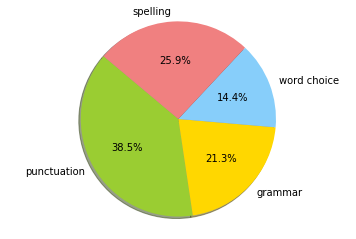

In [61]:
# Plot the distribution of 4 types of error
plt.pie(type_er_dist.values(), labels=type_er_dist.keys(), colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Process each essay and find similar error

### Word Choice

In [23]:
# input: and essay with plain_text and markup
# output: return a list of similar errors of word_choice with number of error for each
# The related words for that error and the indices (on markup) of that error
def word_choice(input):
    output = []
    check = False
    for i in range(len(input['markup'])):
        error = input['markup'][i]
        check = False
        if error['type'] == 'word choice':
            # Check if we see this error before, update the error_count
            for item in output:
                if ((error['old_text'] in item['words']) or
                   (error['new_text'] in item['words'])):
                        check = True # Set this error already marked
                        item['index'].append(i)                          
                        item['words'].add(error['old_text'])
                        if error['new_text'] != None and error['new_text'] != '':
                            item['words'].add(error['new_text'])
                        item['error_count'] = item['error_count'] + 1
            
            # The error haven't been seen before
            if check == False:
                if error['new_text'] != None: 
                    output.append({'words' : {error['old_text'], error['new_text']}, 
                               'index' : [i], 'error_count' : 1})
                else: 
                    output.append({'words' : {error['old_text']}, 
                               'index' : [i], 'error_count' : 1})
                
                
    # Return output
    return output          

In [25]:
word_choice_test = {'plaintext' : 'aaaaa', 'markup' : [{'start_index': 6,
                      'end_index': 11,
                      'old_text': 'dad',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''}, 
                      {'start_index': 10,
                      'end_index': 11,
                      'old_text': 'dady',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''},
                      {'start_index': 20,
                      'end_index': 25,
                      'old_text': 'mom',
                      'new_text': 'mother',
                      'type': 'word choice',
                      'comment': ''}]}

In [26]:
ck.word_choice(word_choice_test)

[{'words': {'dad', 'dady', 'father'}, 'index': [0, 1], 'error_count': 2},
 {'words': {'mom', 'mother'}, 'index': [2], 'error_count': 1}]

#### Running word_choice checking similar error on grade 4 essay dataset to check if student offen repeat word_choice error in an essay


In [27]:
wc_freq = [wc_error['error_count'] for essay in data for wc_error in ck.word_choice(essay)]
wc_freq_dict = nltk.FreqDist(wc_freq)

In [28]:
wc_freq_dict.most_common(5)

[(1, 400), (2, 43), (3, 6), (6, 2), (4, 2)]

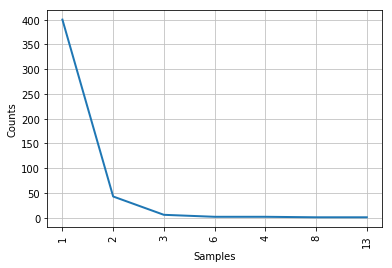

In [29]:
wc_freq_dict.plot()

In [30]:
# Total number repeated error
wc_repeated_cnt = sum([1 for cnt in wc_freq if cnt > 1])

# Total number of different word_choice error
wc_total = sum(wc_freq)

# In total all the word_choice error, the pecent of error appear more than 1 in an essay
(wc_repeated_cnt * 100.0) / wc_total

10.091743119266056

#### Find the most common word choice error that all student made

In [31]:
# Tuple of set of word of word choice error and its appearance
word_set_freq = [[wc_error['words'], wc_error['error_count']] for essay in data for wc_error in ck.word_choice(essay)]
word_set_freq_merge = []
rm_index_set = set()
for i in range(len(word_set_freq)):
    if i not in rm_index_set:
        c = word_set_freq[i]
        for j in range(i+1, len(word_set_freq)):
            if j not in rm_index_set:
                tmp = word_set_freq[j]
                for w in tmp[0]:
                    if w in c[0]:
                        c[1] = c[1] + tmp[1]
                        rm_index_set.add(j)
                        break        
        word_set_freq_merge.append(c)
        
word_set_freq_dict =  nltk.FreqDist([', '.join(err[0]) for err in word_set_freq_merge for i in range(err[1])])     
word_set_freq_dict.most_common(10)       

[(', it', 51),
 ('and, also', 34),
 ('are, is', 17),
 (' For example,,  ', 13),
 ('there, their', 13),
 ('to, do', 9),
 ('of, or', 8),
 ('the', 8),
 ('., stone.', 6),
 ('then', 6)]

### Punctuation Error

In [32]:
puct_error = [error for essay in data for error in essay['markup'] if error['type'] == 'punctuation']

In [33]:
len(puct_error)

1449

In [34]:
puct_error[:2]

[{'start_index': 6,
  'end_index': 11,
  'old_text': 'there',
  'new_text': 'there.',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 58,
  'end_index': 59,
  'old_text': '.',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''}]

#### Test run on a custom input and on data

In [35]:
punctuation_test = {'plaintext' : 'aaaaa', 'markup' : [
                    {'start_index': 1824,
                  'end_index': 1825,
                  'old_text': '',
                  'new_text': '.',
                  'type': 'punctuation',
                  'comment': ''}, 
                    {'start_index': 138,
                   'end_index': 139,
                   'old_text': '.',
                   'new_text': '?',
                   'type': 'punctuation',
                   'comment': ''},
                      {'start_index': 235,
                  'end_index': 236,
                  'old_text': '',
                  'new_text': ',',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 400,
                  'end_index': 401,
                  'old_text': 't',
                  'new_text': 'T',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 592,
                  'end_index': 594,
                  'old_text': 'f',
                  'new_text': '.  F',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 620,
                  'end_index': 621,
                  'old_text': 'w',
                  'new_text': 'W',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 67,
                  'end_index': 78,
                  'old_text': 'is surprise',
                  'new_text': 'is, surprise',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 398,
                  'end_index': 406,
                  'old_text': 'is three',
                  'new_text': 'is, three',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 407,
                  'end_index': 421,
                  'old_text': "strikes you're",
                  'new_text': "strikes, you're",
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'I',
                  'new_text': None,
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'w',
                  'new_text': 'Well',
                  'type': 'punctuation',
                  'comment': ''},
            ]}

In [36]:
ck.punctuation_error(data[9])

{'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'index': [0],
  'error_count': 1},
 'other_error': {'definition': 'other errors',
  'index': [1, 3, 5, 7, 9],
  'error_count': 5},
 'error_use .': {'definition': 'Wrong used or missing using of .',
  'index': [2],
  'error_count': 1},
 'capitalization_error': {'definition': 'Errors on capitalization',
  'index': [4],
  'error_count': 1}}

In [37]:
data[9]['markup']

[{'start_index': 138,
  'end_index': 139,
  'old_text': '.',
  'new_text': '?',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 147,
  'end_index': 148,
  'old_text': 'w',
  'new_text': 'Well',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 231,
  'end_index': 232,
  'old_text': ' ',
  'new_text': ' .',
  'type': 'punctuation',
  'comment': 'add period'},
 {'start_index': 232,
  'end_index': 233,
  'old_text': 't',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 337,
  'end_index': 338,
  'old_text': 'i',
  'new_text': 'i',
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 603,
  'end_index': 607,
  'old_text': 'also',
  'new_text': None,
  'type': 'punctuation',
  'comment': ''},
 {'start_index': 700,
  'end_index': 704,
  'old_text': 'good',
  'new_text': 'well',
  'type': 'word choice',
  'comment': ''},
 {'start_index': 753,
  'end_index': 755,
  'old_text': 'my',
  'new_text': None,
  'type': 'punctuation',
  'comm

In [38]:
ck.punctuation_error(punctuation_test)


{'error_use .': {'definition': 'Wrong used or missing using of .',
  'index': [0, 4],
  'error_count': 2},
 'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'index': [1],
  'error_count': 1},
 'error_use ,': {'definition': 'Wrong used or missing using of ,',
  'index': [2, 6, 7, 8],
  'error_count': 4},
 'capitalization_error': {'definition': 'Errors on capitalization',
  'index': [3, 5],
  'error_count': 2},
 'other_error': {'definition': 'other errors',
  'index': [9, 10],
  'error_count': 2}}

#### Make sure that total error we count equal total of punctuation error in input

In [39]:
assert(len([k for k in punctuation_test['markup'] if k['type'] == 'punctuation']) == 
       sum(error['error_count'] for error in ck.punctuation_error(punctuation_test).values()))

In [40]:
for essay in data:
    assert(len([p for p in essay['markup'] if p['type'] == 'punctuation']) == 
           sum(error['error_count'] for error in ck.punctuation_error(essay).values()))

#### Some Stat for counting punctuation error

##### Total Number of punctuation errors were marked

In [41]:
total_punc_error = len([error for essay in data 
                        for error in essay['markup'] 
                        if error['type'] == 'punctuation'])
total_punc_error

1449

##### Total Number of punctuation errors that we can classify (Not put on other_error)

In [42]:
ctb_punc_error = sum([error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error'])
ctb_punc_error

1034

##### Percent of punctuation error that we can classify

In [43]:
Punc_classify_rate = (ctb_punc_error * 100.0) / total_punc_error
Punc_classify_rate

71.35955831608005

##### Distribution of the repeatable of a type of error in an essay
We want to check how frequently a student make the same punctuation error in an essay

In [44]:
# A list of number of each type of punctuation error in an essay for the whole dataset
repeat_error_cnt = [error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

In [45]:
error_cnt_freq = nltk.FreqDist(repeat_error_cnt)
error_cnt_freq.most_common(5)

[(1, 134), (2, 66), (3, 40), (4, 17), (7, 14)]

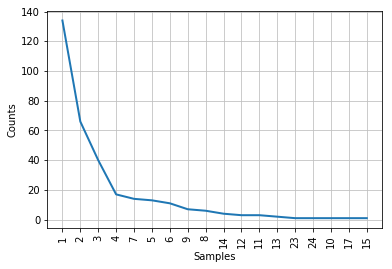

In [46]:
error_cnt_freq.plot()

In [67]:
# Number of repeated error
punc_repeated_cnt = sum([num for num in repeat_error_cnt if num > 1])
punc_repeated_cnt

900

In [66]:
# Percent of repeated punctuation error 
punc_repeated_cnt/total_punc_error

0.6211180124223602

##### Now we want to find for all student in grade 4, which punctuation errors that they usually make

In [48]:
# List of All punc_error in all essays after classify
punc_errors = [error for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

# All different error types
punc_error_type = set([p_type[0] for p_type in punc_errors])
punc_error_type



{'capitalization_error',
 'error_use !',
 'error_use "',
 "error_use '",
 'error_use ,',
 'error_use -',
 'error_use .',
 'error_use :',
 'error_use ?',
 'misleading !?',
 'misleading ,.',
 'misleading ,?',
 'misleading -.',
 'misleading .!',
 'misleading .,',
 'misleading .?',
 "misleading :'",
 'misleading ?,',
 'misleading ?.'}

In [49]:
# Each type with total number of appearance
error_cnt_total = {key : sum([error[1]['error_count'] 
                              for error in punc_errors if error[0] == key]) 
                   for key in punc_error_type} 

error_cnt_total

{'misleading .?': 20,
 'misleading .!': 3,
 'misleading ?,': 1,
 'misleading !?': 5,
 'error_use "': 1,
 'misleading -.': 1,
 'misleading ,.': 23,
 'error_use .': 229,
 'misleading ,?': 4,
 'misleading ?.': 4,
 "error_use '": 22,
 'capitalization_error': 110,
 'error_use ,': 544,
 'error_use -': 7,
 'error_use ?': 35,
 'error_use :': 4,
 'error_use !': 2,
 "misleading :'": 1,
 'misleading .,': 18}

In [50]:
# There still dublicated in the ressult like 'misleading ,?' and 'misleading ?,'
# We're going to merge them
error_cnt_total_fix = error_cnt_total.copy()
for k in error_cnt_total:
    if(k[:10] == 'misleading' and k in error_cnt_total_fix):
        deleted_key = 'misleading ' + k[12] + k[11]
        if deleted_key in error_cnt_total_fix:
            error_cnt_total_fix[k] = error_cnt_total_fix[k] + error_cnt_total_fix[deleted_key]
            del error_cnt_total_fix[deleted_key]
error_cnt_total_fix

{'misleading .?': 24,
 'misleading .!': 3,
 'misleading ?,': 5,
 'misleading !?': 5,
 'error_use "': 1,
 'misleading -.': 1,
 'misleading ,.': 41,
 'error_use .': 229,
 "error_use '": 22,
 'capitalization_error': 110,
 'error_use ,': 544,
 'error_use -': 7,
 'error_use ?': 35,
 'error_use :': 4,
 'error_use !': 2,
 "misleading :'": 1}

In [75]:
punc_error_cnt_total_dict = nltk.FreqDist(error_cnt_total_fix)
punc_error_cnt_total_dict.most_common(5)

[('error_use ,', 544),
 ('error_use .', 229),
 ('capitalization_error', 110),
 ('misleading ,.', 41),
 ('error_use ?', 35)]

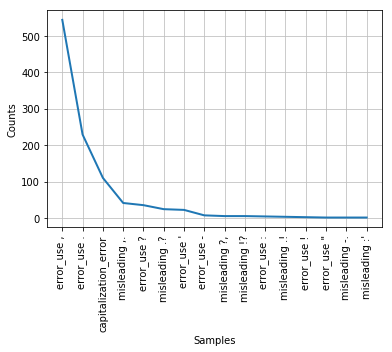

In [76]:
punc_error_cnt_total_dict.plot()

## Spelling

['instants', 'grey', 'wolfs', 'wolfs', 'grey'] ['instance', 'gray', 'wolves', 'wolves', 'gray']
instants instants
instants
nstants
istats
istats
intant
insans
instnts
istats
istats
insans
intant
instants grey
None
instants wolfs
s
instants wolfs
s
grey instants
None
grey grey
grey
rey
gey
gre
grey wolfs
None
grey wolfs
None
wolfs instants
s
wolfs grey
None
wolfs wolfs
wolfs
olfs
wlfs
wofs
wolfs wolfs
wolfs
olfs
wlfs
wofs
wolfs instants
s
wolfs grey
None
wolfs wolfs
wolfs
olfs
wlfs
wofs
wolfs wolfs
wolfs
olfs
wlfs
wofs
common error patterns ['wofs']
common error words [['wolfs', 'wolfs']]
percentage of common errors: 40.0


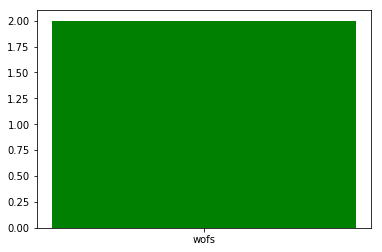

In [77]:
def sub(str1,str2): 
    seqMatch = SequenceMatcher(None,str1,str2) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2)) 
    if (match.size!=0):
        z=str1[match.a: match.a + match.size]
        return z
    
def de(str1,str2,str3):
    a=dict()
    c=None
    for i in str1:
        for j in str2:
            if(i==j and str1.index(i)==str2.index(j)):
                c=str1.replace(i,'')
                print(c)
                
    if c==None:
        return
    if c not in a.keys():
        a[c]=[str1,str3]
    else:
        a[c]=a[c]+[str1,str3]
    return a
	
a=[error['old_text'] for error in data[4]['markup'] if error['type'] == 'spelling']
b=[error['new_text'] for error in data[4]['markup'] if error['type'] == 'spelling']
print(a,b)
co=0
e=dict()  
for i in range(0,len(a)-1):
    for j in range(0,len(a)-1):
        print(a[i],a[j])
        c=sub(a[i],a[j])
        print(c)
        if(c!=None and len(c)>1 and b[j]!=None):
            e=de(a[j],b[j],a[i])
        

        
r1=0
g=dict()
for i in e.keys():
    if len(e[i])>1:
        g[i]=len(e[i])
        r1=r1+len(e[i])
        
print("common error patterns",end=' ')
print([i for i in e.keys() if len(e[i])>1])
print("common error words", end=' ')
print([v for v in e.values() if len(e[i])>1] )

    
print("percentage of common errors:",end=' ')
if(len(a)!=0):
    print((r1*100)/len(a))
else:
    print("No spelling errors found")

plt.bar(g.keys(), g.values(), 1, color='g')
plt.show()


# Summary

### Percent of error can be classified

In [78]:
# Total Error can classify
total_err_classify = ctb_punc_error + wc_total + sp_total
total_err_classify


2550

In [79]:
# Percent of errors can classify
total_err_classify * 100.0 / total_error_cnt

67.71109930961232

### Percent of error is duplicated in an essay

In [80]:
# Number of dublicated error (appearing more than 2 in an essay)
dub_cnt = punc_repeated_cnt + wc_repeated_cnt # + Spelling
dub_cnt

955

In [81]:
# percentage
dub_cnt * 100.0 / total_err_classify

37.450980392156865

### Which is the most common error for all students in those three type

In [87]:
# Gather all the FreqDist of those 3 type
total_error_freq_dist = word_set_freq_dict + punc_error_cnt_total_dict  # + Spelling

In [88]:
# Most common error of all three type
total_error_freq_dist.most_common(20)

[('error_use ,', 544),
 ('error_use .', 229),
 ('capitalization_error', 110),
 (', it', 51),
 ('misleading ,.', 41),
 ('error_use ?', 35),
 ('and, also', 34),
 ('misleading .?', 24),
 ("error_use '", 22),
 ('are, is', 17),
 (' For example,,  ', 13),
 ('there, their', 13),
 ('to, do', 9),
 ('of, or', 8),
 ('the', 8),
 ('error_use -', 7),
 ('., stone.', 6),
 ('then', 6),
 ('in', 6),
 ("you're, your", 6)]